## Mengimport library yang dibutuhkan

In [1]:
##import all the required libraries
import pandas as pd
import numpy as np
import unicodedata
import nltk
import seaborn as sns
from collections import Counter
import nltk
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
from gensim.models import word2vec
from sklearn import manifold
import itertools
import time
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim import corpora
from gensim import models
from gensim import similarities

In [2]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\AMRINA\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\AMRINA\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Membaca data, informasi data

In [3]:
train = pd.read_csv("data/resep_dataset2.csv")
train.Bahan.head()

0    Ayam, potong jadi 10 bagian  -  900 gram Garam...
1    Tepung tapioka  -  150 gram Tepung terigu  -  ...
2    Kangkung  -  1 ikat Kacang panjang  -  1 ikat ...
3    Kuning telur  -  4 butir Minyak goreng  -  40 ...
4    Telur  -  4 butir Gula pasir  -  70 gram Emuls...
Name: Bahan, dtype: object

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1353 entries, 0 to 1352
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Judul   1353 non-null   object
 1   Url     1353 non-null   object
 2   Bahan   1353 non-null   object
 3   Step    1353 non-null   object
dtypes: object(4)
memory usage: 42.4+ KB


# Prepocessing Data

In [5]:
def clean_number(text):
    text = re.sub(r'\w*\d+\w*', '', str(text))
    return text

In [6]:
#casefolding
def token_lower(text):
    text = ''.join(str(text)).lower() # lowercase text
    return text

#Remove Puncutuation
clean_spcl = re.compile('[/(){}\[\]\|@,;]')
clean_symbol = re.compile('[^0-9a-z]')
def clean_punct(text):
    text = clean_spcl.sub('', text)
    text = clean_symbol.sub(' ', text)
    return text

#menghapus double atau lebih whitespace
def _normalize_whitespace(text):
    corrected = str(text)
    corrected = re.sub(r"//t",r"\t", corrected)
    corrected = re.sub(r"( )\1+",r"\1", corrected)
    corrected = re.sub(r"(\n)\1+",r"\1", corrected)
    corrected = re.sub(r"(\r)\1+",r"\1", corrected)
    corrected = re.sub(r"(\t)\1+",r"\1", corrected)
    return corrected.strip(" ")


In [7]:
#stopword
#clean stopwords
stopwords_indonesian = set(stopwords.words('indonesian'))
# Hapus kata "tahu" dari daftar stopwords
stopwords_indonesian.discard("tahu")

takaran = ['gram', 'sdt', 'sdm', 'buah', 'ml', 'mililiter', 'cup', 'gelas', 'tsp', 'tbsp', 'liter', 'g', 'kg',
           'kilogram', 'pound', 'ons', 'pint', 'pt', 'c', 'celcius', 'f', 'fahrenheit', 'derajat', 'm', 'meter',
           'mm', 'milimeter', 'ruas', 'cm', 'centimeter', 'senti', 'centi', 'siung', 'lembar', 'tangkai', 'batang',
           'butir', 'slice', 'keping', 'kotak', 'papan', 'genggam', 'sejumput', 'bungkus', 'sachet', 'dcc', 'piring',
           'cincin', 'grambahan', 'sendok', 'porsi', 'kantung', 'kantong', 'scoop', 'skup', 'scop', 'loyang', 'segenggam',
           'buntil', 'ikat', 'double', 'botol', 'pack', 'siung','diameter', 'ekor', 'kuntum', 'bonggol']

word_to_remove = [ "a", "acting", "adaan", "adon", "aduk", "air", "alas", "aluminium", "ambil", "ampas", "aneka", "anti",
                  "api" "arik", "asap", "ayak", "b", "bagi", "bagus", "bahan", "bakar", "baluran", "bambu", "bantu", "basah", "basic", "batu" 
                  "batangsaus", "belah", "beli", "bening", "bentuk", "berat", "bersih", "berseta", "beserta" "biar", "bilas", 
                  "blender", "bola", "buahbahan", "buahsaus", "buahlainnya", "buahkuah", "buahpencelup", "buang", "bulat", 
                  "bunda", "butir", "butirkuah", "bumbu", "cabut", "cacah", "cair", "cairkan", "campur", "celup", "cepat", 
                  "cetak", "cincang", "cocolan", "cuci", "dadu", "dasar", "diam", "dibagi", "dibentuk" "didih",  "digeprek", 
                  "dingin", "diiikat", "dimemarkan", "dipulung", "direbus", "disangrai", "diseduh", "ditorch", "duri", 
                  "ekorbumbu", "empuk", "encer", "encerkan", "endapan", "es", "fillet", "filling", "foil", "formula", "garam", 
                  "garnish", "gepeng", "geprak", "geprek", "gigi", "gramisi", "gramlapisan", "gramtaburan", "gula", "gurih", 
                  "goreng", "goyang", "hancur", "hangat", "hangatkan", "halus", "hasil", "hias", "i", "ii", "iii", "iv", "ikat", 
                  "instan", "iris", "isi", "jala", "jam", "jari", "jaripelengkap", "jenis", "jumput", "k", "kain", "kaku", "kapal", 
                  "kasar", "kasir", "kasur", "kedalam", "kerat", "kerok", "kocok", "kocock", "kondisi", "konsistensi", "korea", 
                  "korek", "kotor", "kuah", "kualitas", "kuku", "kukus", "kulkas", "kupas", "larut", "larutkan", "lauk", "lapis", 
                  "lawan", "lebar", "lebih", "leleh", "lelehkan", "lembarbumbu", "lembarlainnya", "lembarpudding", "lembartaburan", 
                  "lembut", "lengkap", "lengket", "lentur", "lepas", "lidi", "lihat", "lilit", "literlainnya", "luar", "lulur", 
                  "lumat", "lumatkan", "lumur", "lumuran", "makan", "mangkuk", "marinasi", "matang", "mekar", "memar", "memarkan", 
                  "menit", "menggoreng", "mengunkep", "mengungkep", "mentah", "menyemat", "menyerong", "merebus", "mlbahan", "mlisi", 
                  "mlfilling", "mlpelengkap", "mlsaus", "mlsambal", "mltaburan", "mltopping", "minimal", "minyak", "mudah", "oil", 
                  "oles", "olesisian", "opsional", "optional", "orak", "panas", "panggang", "pakai", "pasir", "papanpelapis", "pecah", 
                  "pecel", "pekat", "pembalur", "penuh", "pera", "peras", "perasan", "perasannya", "perlembar", "persannya", "peta", "parut",
                  "petik", "pilih", "pipil", "pisah", "plastik", "potong", "protein", "puter", "putus", "rajang", "rambut", "rasa", 
                  "ready", "rebus", "rebusan" "rekat", "remas", "rendah", "rendam", "resep", "robek", "ruang", "sangrai", "sampai", 
                  "saring", "sebentar", "secukupnya", "secukupnyaes", "secukupnyisi", "secukupnyaisian", "secukupnyatumisan", 
                  "secukupnyalainnya", "secukupnyaperendam", "secukupnyakaldu", "secukupnyabubur", "secukupnyabiang", "secukupnyalapisan", 
                  "sedang", "seduh", "sdtserundeng", "sdtsaus", "sdtbaluran", "sdttopping", "sdtlainnya", "sdtmerebus", "sdtcuko", 
                  "sdtpencelup", "sdtbahan", "sdtgarnish", "sdtsambal", "sdtperendam", "sdttaburan", "sdtolesan", "segar", "seger", 
                  "sejumpuhkuah", "sejumputkulit", "sela", "selam", "semalam", "semalaman", "selera", "serat", "serong", "serut", 
                  "serutan", "sesuai", "setengah", "seujung", "siangi", "sikat", "simpul", "simpukan", "simpulkan", "siram", "sisa", 
                  "sisir", "siungbumbu", "siungpelapis" "sdmisi", "sdmtaburan", "sdmbahan", "sdmcuko", "sdmuleg", "sdmserundeng", "sd", 
                  "sobek", "spread", "suhu", "suir", "suwir", "tabur", "taburan", "tali", "tambah", "tangan", "tahan", "tbmsp", "tebal", 
                  "tengah", "tetes", "tetessaus", "tinggi", "tintanya", "tipis", "tiris", "tlapisan", "to", "topping", "torch", "tua", "tumbuk", 
                  "tumis", "tusuk", "ukur", "ulek", "uleg", "utuh", "variasi", "versi", "wadah", "wajan"
                 ]

def clean_stopwords(text):
    words = text.split()
    cleaned_words = [word for word in words if word.lower() not in stopwords_indonesian and
                     word.lower() not in takaran and word.lower() not in word_to_remove]
    cleaned_text = ' '.join(cleaned_words)
    return cleaned_text

In [8]:
import simplemma
def lemmatization(text):
    text = ' '.join(simplemma.lemmatize(word, lang='id') for word in text.split() if word in text)
    return text 

In [9]:
from nltk.tokenize import word_tokenize

def tokenize_sentence(sentence):
    multi_word_tokens = [
        "abon ayam", "abon sapi", "agar agar", "asam gelugur", "asam jawa", "asam kandis", "asam sunti" "ati ampela", "ati ampela ayam", "ayam kampung", "ayam jantan", 
        "babat sapi", "baby buncis", "baby cumi", "baby kailan", "baby kol",  "baby potato", "bakso ayam", "bakso sapi", "baking soda", "bawang bombay", 
        "bawang bombai", "bawang merah", "bawang putih", "bawang putih bubuk", "baking powder", "bawang prei", "belimbing sayur", "belimbing wuluh", 
        "beras jagung", "beras ketan putih", "beras basmati", "beras ketan", "biji selasih", "biskuit susu", "biskuit oreo", "biskuit marie regal", "bread crumbs", "bread improver",
        "brown sugar", "buah cherry", "buah naga", "buah naga merah", "bubuk spekuk", "bubuk kari", "bunga cengkeh", "bunga genjer", "bunga kecombrang", "bunga lawang", 
        "bunga kol", "bunga sedap malam", "bunga pepaya", "buntut sapi", "butter cream", "cabai merah", "cabai merah besar", "cabai merah keriting", 
        "cabai rawit", "cabai rawit merah", "cabai rawit hijau",  "cabai bubuk", "cabai hijau", "cabai hijau besar", "cake emulsifier", "cabe keriting", 
        "cabai keriting", "cakalang fufu", "ceker ayam", "cheese spread", "chia seed", "choco chips", "coklat bubuk", "cokelat bubuk", "coklat putih",  "chicken katsu", 
        "corn syrup", "cooking cream", "crab stick", "cream cheese", "cream of tartar", "cumi cumi", "daging ayam", "dada ayam", "daging giling", "daging ikan", "daging kambing", "daging sapi", 
        "daging sapi sandung lamur", "daging sapi has dalam", "daun bawang", "daun bayam", "daun cengkeh", "daun cincau", "daun bawang", "daun jeruk", "daun jeruk purut", "daun kari", "daun katuk", 
        "daun kemangi", "daun kol", "daun kunyit", "daun ketumbar", "daun melinjo", "daun mint", "daun pala", "daun pandan", "daun pepaya", "daun pisang", "daun salam", "daun selada", "daun seledri", 
        "daun serai" "daun singkong", "english muffin", "es batu", "essence vanilla", "french fries", "gabin tawar", "gula aren", "gula bubuk", "gula merah", "green tea", "hati sapi", "ice cream", "iga kambing", 
        "iga sapi", "ikan nila", "ikan kembung", "ikan mujair", "ikan mas", "ikan bandeng", "ikan selar", "ikan teri", "ikan gabus", "ikan patin", "ikan tuna", "ikan tongkol", "ikan cakalang", "ikan salmon", 
        "ikan salai", "ikan lele", "ikan gurame", "ikan kakap", "ikan tenggiri", "ikan bawal", "ikan kerapu", "ikan peda", "ikan salem", "ikan asin", "ikan dori", 
        "ikan pe", "jambal roti", "jamur kancing", "jamur kuping",  "jamur hioko", "jamur enoki", "jamur shitake", "jamur champignon", "jamur tiram", "jamur merang", "jambu air", 
        "jantung pisang", "jeruk nipis", "jeruk limau", "jeroan kambing", "jeruk kasturi", "jeruk purut", "jambu air", "jambu biji merah",  "jambu biji", "jeroan sapi", "kacang tanah", 
        "kayu manis",  "kaldu ayam",  "kaldu ayam bubuk", "kaldu bubuk", "kaldu jamur", "kaldu jamur bubuk",  "kaldu sapi", "kaldu udang", "kacang almond", "kacang hijau", "kacang merah", 
        "kacang mede", "kacang kapri", "kacang kedelai", "kacang kenari", "kacang tanah", "kacang panjang", "kacang polong", "kaki kambing", "kaki sapi", "kapur sirih", "kayu manis", "kerang dara", 
        "kembang tahu", "kembang turi", "kecap manis", "kecap ikan", "ketan hitam", "kelapa parut",  "kecap inggris", "kecap asin", "keju cheddar", "keju edam", "keju parmesan", 
        "keju slice", "keju spread", "keju mozarella", "kerang hijau", "kerupuk kanji", "kerupuk krecek", "kerupuk kulit", "kerupuk merah", "kerupuk udang", "kelapa muda", "kembang turi", "kental manis", 
        "kentang goreng", "ketumbar bubuk", "kikil sapi", "kulit pangsit", "kulit lumpia", "kuning telur", "kulit melinjo", "kulit pastry", "kol putih", "kol ungu", "kol merah", "kolang kaling", "krim whipping", 
        "krimer kental manis", "labu kuning", "labu siam", "lada bubuk", "lemak sapi", "lemon cui", "lidah buaya", "lidah sapi", "lobak putih", "mangga kweni", "matcha powder", "melinjo merah", "melinjo hijau", 
        "merica bubuk", "mie kuning", "nasi putih", "nasi shirataki", "nata de coco", "paha ayam", "pala bubuk", "palm sugar", "paprika hijau", "paprika kuning", "paprika merah", "pasta coklat", "pasta mocca", "paru sapi", "petis udang", "pindang tongkol", "pisang ambon", 
        "pisang candi", "pisang kapok", "pisang kepok", "pisang klutuk", "pisang lilin", "pisang mas", "pisang raja", "pisang tanduk", "pisang uli", "putih telur", "quaker oat", "ragi instant", "rice noodles", "roti burger", "roti john", 
        "roti tawar", "rumput laut", "santan instan", "sayap ayam", "sagu mutiara", "sambal terasi", "sandung lamur", "saus sambal", "saus tartar", "saus tomat", "saus tiram", "sawi putih", "selai coklat", 
        "selai coklat", "selai strawberry", "selai kacang", "selai nanas", "smoked beef", "soda kue", "soft cream", "sosis ayam", "sosis sapi", "star anise", "susu bubuk", "susu cair", "susu evaporasi", 
        "susu full cream", "susu kedelai", "susu kental manis", "susu uht", "susu sapi", "tahu cina", "tahu coklat", "tahu gembos", "tahu jepang", "tahu kuning", "tahu kulit", "tahu putih", 
        "tahu pong", "tahu sutra", "tahu sumedang", "tape ketan", "tape singkong", "tape ketan hitam", "tetelan sapi", "telur asin", "telur ayam", "telur bebek", "telur ikan", 
        "telur puyuh", "temu kunci", "tepung beras", "tepung hunkwe", "teri nasi", "tepung kanji", "tepung ketan", "tepung ketan putih", "tepung panir", "tepung roti", "tepung sagu", 
        "tepung tapioka", "tepung terigu", "tepung maizena", "teri nasi medan", "teri medan", "timun suri", "timun jepang" "tomat merah", "tomat hijau", "tulang ayam", "tulang daging", "tulang kambing", 
        "tulang kaki sapi", "tulang jambal roti", "tulang rangu", "ubi merah", "ubi ungu", "ubi cilembu", "ubi jalar", "ubi kuning", "ubi orange", "unsalted butter", "usus ayam", "urat sapi", "whipping cream", "wijen sangrai"
    ]
    
    # Replace multi-word tokens with versions that have spaces
    for token in multi_word_tokens:
        space_removed_token = token.replace(" ", "")
        sentence = sentence.replace(space_removed_token, token)

    # Tokenize the sentence based on spaces
    words = sentence.split()

    # Create tokens by combining two and three consecutive words
    combined_tokens = []
    i = 0
    while i < len(words):
        two_word_token = " ".join(words[i:i+2])
        three_word_token = " ".join(words[i:i+3])

        if three_word_token in multi_word_tokens:
            combined_tokens.append(three_word_token)
            i += 3
        elif two_word_token in multi_word_tokens:
            combined_tokens.append(two_word_token)
            i += 2
        else:
            combined_tokens.append(words[i])
            i += 1

    # Remove duplicates
    unique_tokens = list(set(combined_tokens))

    return unique_tokens

In [10]:
def bahan_parser(text):
    synonym_mapping = {
        'kubis': 'kol',
        'daun cengkeh': 'ceengkeh',
        'baby kol': 'cuciwis',
        'pekak': 'bunga lawang',
        'kembang lawang': 'bunga lawang',
        'kembang kol': 'bunga kol',
        'bawang bombai': 'bawang bombay',
        'terigu': 'tepung terigu',
        'maizena': 'tepung maizena',
        'tapioka': 'tepung tapioka',
        'kental manis': 'susu kental manis',
        'coklat': 'cokelat',
        'mete': 'kacang mete',
        'almond': 'kacang almond',
        'daun kol': 'kol',
        'daging ayam': 'ayam',
        'selasih': 'biji selasih',
        'agar': 'agar agar',
        'cherry': 'buah cherry',
        'belimbing sayur': 'belimbing wuluh',
        'santan instan': 'santan',
        'star anise': 'bunga lawang',
        'pete': 'petai',
        'bawang prei': 'daun bawang',
        'whipcream': 'whipping cream',
        'laos': 'lengkuas',
        'jeruk kasturi': 'lemon cui',
        'tahu sutra': 'tahu jepang',
        'whip cream': 'whipping cream',
        'daun bayam': 'bayam',
        'pindang tongkol': 'ikan tongkol',
        'tongkol': 'ikan tongkol',
        'sereh': 'serai',
        'daun serai': 'serai',
        'tomat merah': 'tomat',
        'kol ungu': 'kol merah',
        'kemangi': 'daun kemangi',
        'toge': 'tauge',
        'bandeng': 'ikan bandeng',
        'bread crumbs': 'breadcrumbs',
        'bread crumbs': 'tepung roti',
        'es batu': 'es',
        'cakalang fufu': 'ikan cakalang',
        'kyuri': 'timun jepang',
        'ceker': 'ceker ayam',
        'nenas': 'nanas',
        'kacang kapri': 'kapri',
        'daging': 'daging sapi',
        'petai': 'pete'
    }

    text = clean_number(text)
    text = token_lower(text)
    text = clean_punct(text)
    text = _normalize_whitespace(text)
    text = lemmatization(text)
    text = clean_stopwords(text)
    
    # Use the modified tokenize_sentence function
    text = tokenize_sentence(text)

    # Replace synonyms using the synonym mapping
    text = [synonym_mapping.get(word, word) for word in text]

    return text

In [11]:
train['clean']= train['Bahan'].apply(bahan_parser)

In [12]:
train['clean']

0       [cabai rawit merah, kelapa, ayam, andaliman, d...
1       [tepung terigu, cabai bubuk, seledri, tepung t...
2       [tauge, kelapa, kacang tanah, kangkung, kacang...
3       [tepung terigu, putih telur, kuning telur, cok...
4       [tepung maizena, pasta, susu bubuk, telur, mok...
                              ...                        
1348    [vanili, tepung terigu, telur, sp, margarin, b...
1349    [kelapa, daun salam, cabai merah, jahe, asam, ...
1350    [mentega, vanili, tepung terigu, ragi, bubuk, ...
1351    [keju cheddar, tepung terigu, butter, susu bub...
1352    [lada, alpukat, daun ketumbar, tomat, bawang b...
Name: clean, Length: 1353, dtype: object

In [13]:
bahan_parser(train.clean[0])

['cabai rawit merah',
 'kelapa',
 'ayam',
 'andaliman',
 'daun jeruk',
 'lengkuas',
 'jeruk nipis',
 'jahe',
 'kunyit',
 'putih',
 'bawang putih',
 'bawang merah',
 'serai']

In [14]:
train

,Judul,Url,Bahan,Step,clean
0,Resep Ayam Panidar,https://resepkoki.id/resep/resep-ayam-panidar/,"Ayam, potong jadi 10 bagian - 900 gram Garam...",Cuci bersih ayam kemudian marinasi dengan gara...,"[cabai rawit merah, kelapa, ayam, andaliman, d..."
1,Resep Moring,https://resepkoki.id/resep/resep-moring/,Tepung tapioka - 150 gram Tepung terigu - ...,"Campur tepung tapioka, terigu, bawang putih, g...","[tepung terigu, cabai bubuk, seledri, tepung t..."
2,Resep Serombotan Klungkung,https://resepkoki.id/resep/resep-serombotan-kl...,Kangkung - 1 ikat Kacang panjang - 1 ikat ...,Rebus masing-masing sayuran dengan sedikit gar...,"[tauge, kelapa, kacang tanah, kangkung, kacang..."
3,Resep Hurricane Cake Roll,https://resepkoki.id/resep/resep-hurricane-cak...,Kuning telur - 4 butir Minyak goreng - 40 ...,"Bahan 1: Campur kuning telur dan susu cair, ad...","[tepung terigu, putih telur, kuning telur, cok..."
4,Resep Bolu Gulung Batik,https://resepkoki.id/resep/resep-bolu-gulung-b...,Telur - 4 butir Gula pasir - 70 gram Emuls...,"Kocok telur, gula pasir dan emulsifier sampai ...","[tepung maizena, pasta, susu bubuk, telur, mok..."
...,...,...,...,...,...
1348,Resep Bolu Panggang Coklat,https://resepkoki.id/resep/resep-bolu-panggang...,Tepung terigu - 150 gram Baking powder - ...,Jadikan 1 semua bahan A dan ayak. Sisihkan.Sia...,"[vanili, tepung terigu, telur, sp, margarin, b..."
1349,Resep Dendeng Batokok,https://resepkoki.id/resep/resep-dendeng-batokok/,Air kelapa - 700 ml Daging sapi - 350 gra...,"Rebus daging tanpa di potong, dengan bumbu reb...","[kelapa, daun salam, cabai merah, jahe, asam, ..."
1350,Resep Kue Cubit,https://resepkoki.id/resep/resep-kue-cubit/,Tepung terigu protein rendah - 100 gram Rag...,"Campurkan semua bahan A, lalu aduk dengan spat...","[mentega, vanili, tepung terigu, ragi, bubuk, ..."
1351,Resep Kue Nastar Keju,https://resepkoki.id/resep/resep-kue-nastar-keju/,Tepung terigu protein sedang - 350 gram Sus...,"Kocok margarin, butter, dan gula halus dengan ...","[keju cheddar, tepung terigu, butter, susu bub..."


In [15]:
train.to_csv('data/train_clean.csv')

In [16]:
#Code to generate bag of words from the cleaned ingredient list
bags_of_words = [Counter(bahan_parser(Bahan)) for Bahan in train.Bahan]

In [17]:
#Find sum of every ingredient using Counter()
sumbags = sum(bags_of_words, Counter())


# Finally, plot the 10 most used ingredients
clean_df = pd.DataFrame.from_dict(sumbags, orient='index').reset_index()
clean_df = clean_df.rename(columns={'index':'Bahan', 0:'count'})
clean_df.to_csv('data/ingredient_clean.csv')

top_ing = clean_df.sort_values('count', ascending=False)

In [18]:
clean_df

,Bahan,count
0,cabai rawit merah,88
1,kelapa,104
2,ayam,165
3,andaliman,4
4,daun jeruk,201
...,...,...
901,kaki,1
902,tunjang,1
903,mocca,1
904,essense,1


In [19]:
ingr_only_dict = clean_df['Bahan'].to_dict()

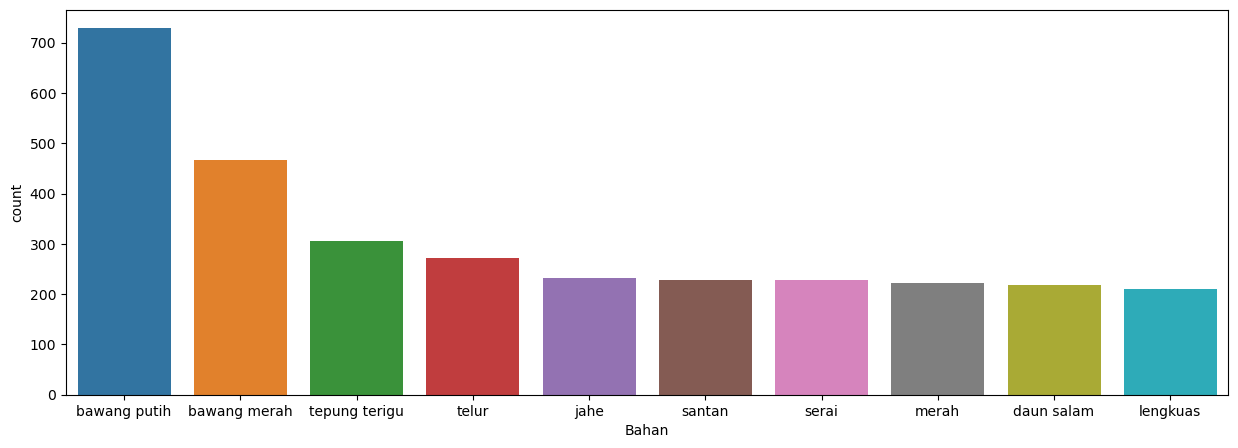

In [20]:
#Plot top ingredients using bag of words
fig, ax = plt.subplots()
fig.set_size_inches(15, 5)
sns.barplot(x = 'Bahan', y = 'count', data = top_ing.head(10))
sns.set_palette("deep")
plt.show()
fig.savefig('ingredient_count_bag_of_words.png')

In [21]:
#Get all clean ingredients in list format per recipe
ingr_list = []
for Bahan in train.Bahan:
    ingr_list.append(bahan_parser(Bahan))

In [22]:
print (ingr_list[0])

['cabai rawit merah', 'kelapa', 'ayam', 'andaliman', 'daun jeruk', 'jeruk nipis', 'jahe', 'kunyit', 'putih', 'bawang putih', 'bawang merah', 'serai', 'lengkuas']


In [23]:
#PMI Calculation starts
#Point-wise mutual information to understand which ingredients go together and which ones don't

#Create combinations of ingredients
start_time = time.time()

l = []
for K in range(len(ingr_list)):
    for L in range(2,3):
        for subset in itertools.combinations(ingr_list[K], L):
            l.append(sorted(subset))       
#print("--- %s seconds ---" % (time.time() - start_time))

In [24]:
print (l[0])

['cabai rawit merah', 'kelapa']


In [25]:
#Function - Point-wise mutual information
def pmi(dff, x, y):
    df = dff.copy()
    df['f_x'] = df.groupby(x)[x].transform('count')
    df['f_y'] = df.groupby(y)[y].transform('count')
    df['f_xy'] = df.groupby([x, y])[x].transform('count')
    df['pmi'] = np.log(len(df.index) * df['f_xy'] / (df['f_x'] * df['f_y']) )
    return df

In [26]:
#Convert list of tuples to dataframe
df = pd.DataFrame(l, columns = ['Ingredient1','Ingredient2'])
print (df.count())

#Eliminate rows where Ingredient1 = Ingredient2
df = df[df['Ingredient1'] != df['Ingredient2']]
print (df.count())

Ingredient1    67519
Ingredient2    67519
dtype: int64
Ingredient1    67484
Ingredient2    67484
dtype: int64


In [27]:
#Calculate PMI
df = pmi(df, 'Ingredient1', 'Ingredient2')
print(df.count())

Ingredient1    67484
Ingredient2    67484
f_x            67484
f_y            67484
f_xy           67484
pmi            67484
dtype: int64


In [28]:
df

,Ingredient1,Ingredient2,f_x,f_y,f_xy,pmi
0,cabai rawit merah,kelapa,582,490,6,0.350529
1,ayam,cabai rawit merah,1727,252,3,-0.765312
2,andaliman,cabai rawit merah,39,252,3,3.025267
3,cabai rawit merah,daun jeruk,582,757,31,1.557799
4,cabai rawit merah,jeruk nipis,582,875,30,1.380149
...,...,...,...,...,...,...
67514,alpukat,tomat,111,1487,2,-0.201253
67515,alpukat,bawang bombay,111,55,2,3.095930
67516,daun ketumbar,tomat,2,1487,1,3.121983
67517,bawang bombay,daun ketumbar,1442,2,1,3.152712


In [29]:
#Eliminate rows for the same ingredient combinations
print (df.pmi.count())
df = df.drop_duplicates()
print (df.pmi.count())

#Sort df
df = df.sort_values('pmi',ascending=False)
df.head()

67484
21789


,Ingredient1,Ingredient2,f_x,f_y,f_xy,pmi
7584,pulen,selongsong,1,3,1,10.021034
1245,abon ayam,abon sapi,3,1,1,10.021034
53674,puding,ramekin,3,1,1,10.021034
14796,creamer,matcha powder,2,2,1,9.733351
66717,swallow,white,1,6,1,9.327886


In [30]:
df.to_csv('data/pmi_ingredient_similarity.csv', encoding = 'utf-8')

In [31]:
df = pd.read_csv('data/pmi_ingredient_similarity.csv')
df = df.sort_values('pmi',ascending=False)
top_df = df.groupby('Ingredient1').head(5)
top_df.to_csv('data/pmi_ingredient_similarity_top.csv')

df = df.sort_values('pmi',ascending=True)
neg_df = df.groupby('Ingredient1').head(5)
neg_df.to_csv('data/pmi_ingredient_similarity_neg.csv')

In [32]:
def merge_two_dicts(x, y):
    z = x.copy()   # start with x's keys and values
    z.update(y)    # modifies z with y's keys and values & returns None
    return z

In [33]:
##Get clean ingredients to be used as an input for word2vec model to identify ingredient similarity.

ingr_clean_df = pd.DataFrame({'Bahan':ingr_list})
#print ingr_clean_df
print (ingr_clean_df)
ingr_clean_df.to_csv('data/ingredient_2_recipe_clean.csv')

                                                  Bahan
0     [cabai rawit merah, kelapa, ayam, andaliman, d...
1     [tepung terigu, cabai bubuk, seledri, tepung t...
2     [tauge, kelapa, kacang tanah, kangkung, kacang...
3     [tepung terigu, putih telur, kuning telur, cok...
4     [tepung maizena, pasta, susu bubuk, telur, mok...
...                                                 ...
1348  [vanili, tepung terigu, telur, sp, margarin, b...
1349  [kelapa, daun salam, cabai merah, jahe, asam, ...
1350  [mentega, vanili, tepung terigu, ragi, bubuk, ...
1351  [keju cheddar, tepung terigu, butter, susu bub...
1352  [lada, alpukat, daun ketumbar, tomat, bawang b...

[1353 rows x 1 columns]


In [34]:
#pip install -U gensim
#Implementing word2vec to get the recipes which are similar to each other
from gensim.models import Word2Vec

# Gabungkan semua list kata menjadi satu list besar
flat_ingr_list = [item for sublist in ingr_list for item in sublist]

# Train the Word2Vec model
num_features = 250  # Word vector dimensionality
context = 1  # Context window size
downsampling = 1e-3  # Threshold for downsampling higher-frequency words
epochs = 95  # Number of training epochs

# Initialize and train the Word2Vec model
model = Word2Vec(sentences=[flat_ingr_list], vector_size=num_features, window=context, sample=downsampling, epochs=epochs)

# Save the trained model
model.save("models/recom.model")



In [35]:
flatten_list = []
for sublist in ingr_list:
    for item in sublist:
        if item not in flatten_list:
            flatten_list.append(item)

In [36]:
flatten_list

['cabai rawit merah',
 'kelapa',
 'ayam',
 'andaliman',
 'daun jeruk',
 'jeruk nipis',
 'jahe',
 'kunyit',
 'putih',
 'bawang putih',
 'bawang merah',
 'serai',
 'lengkuas',
 'tepung terigu',
 'cabai bubuk',
 'seledri',
 'tepung tapioka',
 'kaldu bubuk',
 'tauge',
 'kacang tanah',
 'kangkung',
 'kacang',
 'terong',
 'cabai merah',
 'cabai rawit',
 'kemiri',
 'merah',
 'kencur',
 'putih telur',
 'kuning telur',
 'coklat bubuk',
 'cokelat',
 'tepung maizena',
 'pasta',
 'susu bubuk',
 'telur',
 'moka',
 'strawberry',
 'margarin',
 'emulsifier',
 'asam jawa',
 'daun salam',
 'daging sapi',
 'cooking',
 'x',
 'vla',
 'pandan',
 'kulit pastry',
 'dark',
 'chocolate',
 'susu full cream',
 'gaplek',
 'kering',
 'singkong',
 'bawang',
 'telur ayam',
 'kayu manis',
 'bunga lawang',
 'cengkeh',
 'daun kari',
 'tepung',
 'kentang',
 'kapulaga',
 'terasi',
 'beras jagung',
 'ikan asin',
 'tahu',
 'beras',
 'sambal terasi',
 'tempe',
 'beras ketan',
 'jus',
 'santan',
 'kental',
 'ketumbar',
 'ketu

In [37]:
most_sim_list = []
corpus_sim_dict = {}
input_list = []
for i in flatten_list:
    try: 
        if len(i) > 0:
            #print i
            corpus_sim_dict.update({i:model.wv.similarity(i,i)})      
    except KeyError:
        pass

In [38]:
corpus_sim_dict

{'cabai rawit merah': 1.0,
 'kelapa': 1.0,
 'ayam': 1.0,
 'daun jeruk': 1.0,
 'jeruk nipis': 0.99999994,
 'jahe': 1.0,
 'kunyit': 1.0,
 'putih': 1.0,
 'bawang putih': 1.0,
 'bawang merah': 1.0,
 'serai': 1.0,
 'lengkuas': 1.0,
 'tepung terigu': 1.0,
 'cabai bubuk': 1.0,
 'seledri': 1.0,
 'tepung tapioka': 1.0,
 'kaldu bubuk': 1.0,
 'tauge': 1.0,
 'kacang tanah': 1.0,
 'kangkung': 1.0,
 'kacang': 1.0,
 'terong': 0.99999994,
 'cabai merah': 1.0,
 'cabai rawit': 1.0,
 'kemiri': 1.0,
 'merah': 1.0,
 'kencur': 1.0,
 'putih telur': 1.0,
 'kuning telur': 1.0,
 'coklat bubuk': 1.0,
 'cokelat': 1.0,
 'tepung maizena': 1.0,
 'pasta': 1.0,
 'susu bubuk': 1.0,
 'telur': 1.0,
 'strawberry': 1.0,
 'margarin': 1.0,
 'emulsifier': 1.0,
 'asam jawa': 1.0,
 'daun salam': 1.0,
 'daging sapi': 1.0,
 'cooking': 1.0,
 'pandan': 1.0,
 'dark': 0.99999994,
 'chocolate': 1.0,
 'susu full cream': 1.0,
 'kering': 1.0,
 'singkong': 1.0,
 'bawang': 1.0,
 'telur ayam': 1.0,
 'kayu manis': 1.0,
 'bunga lawang': 1.0,


In [39]:
model.wv.most_similar('keju')

[('pasta coklat', 0.818085253238678),
 ('butter cream', 0.8006120920181274),
 ('soda kue', 0.7934755086898804),
 ('cream cheese', 0.75589919090271),
 ('ragi instant', 0.7266612648963928),
 ('pisang ambon', 0.7223324775695801),
 ('kacang almond', 0.715034544467926),
 ('cooking', 0.7097181081771851),
 ('meses', 0.7004563212394714),
 ('baking soda', 0.6883177161216736)]

In [40]:
model.wv.most_similar('tepung terigu')

[('mentega', 0.6309353113174438),
 ('keju', 0.6238778829574585),
 ('soda kue', 0.610260546207428),
 ('butter cream', 0.6021658778190613),
 ('pasta', 0.5985458493232727),
 ('tepung kanji', 0.588525116443634),
 ('pasta coklat', 0.5709187388420105),
 ('spaghetti', 0.5441538691520691),
 ('smoked beef', 0.5431873798370361),
 ('meses', 0.5429513454437256)]

In [41]:
dictionary = corpora.Dictionary(ingr_list)
#print(dictionary)
print(dictionary.token2id)

{'andaliman': 0, 'ayam': 1, 'bawang merah': 2, 'bawang putih': 3, 'cabai rawit merah': 4, 'daun jeruk': 5, 'jahe': 6, 'jeruk nipis': 7, 'kelapa': 8, 'kunyit': 9, 'lengkuas': 10, 'putih': 11, 'serai': 12, 'cabai bubuk': 13, 'kaldu bubuk': 14, 'seledri': 15, 'tepung tapioka': 16, 'tepung terigu': 17, 'cabai merah': 18, 'cabai rawit': 19, 'kacang': 20, 'kacang tanah': 21, 'kangkung': 22, 'kemiri': 23, 'kencur': 24, 'merah': 25, 'tauge': 26, 'terong': 27, 'cokelat': 28, 'coklat bubuk': 29, 'kuning telur': 30, 'putih telur': 31, 'emulsifier': 32, 'margarin': 33, 'moka': 34, 'pasta': 35, 'strawberry': 36, 'susu bubuk': 37, 'telur': 38, 'tepung maizena': 39, 'asam jawa': 40, 'daging sapi': 41, 'daun salam': 42, 'chocolate': 43, 'cooking': 44, 'dark': 45, 'kulit pastry': 46, 'pandan': 47, 'susu full cream': 48, 'vla': 49, 'x': 50, 'gaplek': 51, 'kering': 52, 'singkong': 53, 'bawang': 54, 'bunga lawang': 55, 'cengkeh': 56, 'daun kari': 57, 'kapulaga': 58, 'kayu manis': 59, 'kentang': 60, 'telur

In [42]:
#Applying doc2bow on the dictionary of ingredients, which converts the ingredient to a number in every recipe
#This input format is needed for TfIdfmodel
bow_corpus = [dictionary.doc2bow(text) for text in ingr_list]
bow_corpus[0]

[(0, 1),
 (1, 1),
 (2, 1),
 (3, 1),
 (4, 1),
 (5, 1),
 (6, 1),
 (7, 1),
 (8, 1),
 (9, 1),
 (10, 1),
 (11, 1),
 (12, 1)]

In [43]:
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import Word2Vec

In [44]:
def get_and_sort_corpus(data):
    corpus_sorted = []
    for doc in data.parsed.values:
        sorted_doc = sorted(doc)
        corpus_sorted.append(sorted_doc)
    return corpus_sorted

In [45]:
from collections import defaultdict

In [46]:
# from sklearn.metrics.pairwise import cosine_similarity
# import pandas as pd
# import numpy as np

# # Contoh data
# input_str = "mie, bayam, telur, sosis, dada ayam"
# input_par = input_str.split(', ')
# data = pd.read_csv("data/resep_dataset2.csv")
# data["parsed"] = data["Bahan"].apply(bahan_parser)
# corpus = get_and_sort_corpus(data)
# model = Word2Vec.load("models/recom.model")
# if model:
#     print("Successfully loaded model")

# # Menghitung rata-rata vektor kata untuk setiap resep
# def get_average_word_vector(words, model, num_features):
#     feature_vector = np.zeros((num_features,), dtype="float32")
#     n_words = 0
#     for word in words:
#         if word in model.wv:
#             n_words += 1
#             feature_vector = np.add(feature_vector, model.wv[word])
#     if n_words > 0:
#         feature_vector = np.divide(feature_vector, n_words)
#     return feature_vector

# # Ensure the vector size matches the model's vector size
# vector_size = model.vector_size

# recipe_vectors = [get_average_word_vector(recipe, model, vector_size) for recipe in corpus]
# input_vector = get_average_word_vector(input_par, model, vector_size)

# # Menghitung cosine similarity
# cosine_similarities = cosine_similarity([input_vector], recipe_vectors)

# # Mendapatkan indeks 5 kemiripan tertinggi
# top_indices = cosine_similarities.argsort()[0][::-1][:5]

# # Menampilkan hasil yang memiliki nilai similarity
# print(f"Input: {input_str}")
# for idx, index in enumerate(top_indices):
#     recipe_title = data.loc[index, "Judul"]
#     recipe = corpus[index]
#     similarity = cosine_similarities[0, index]
    
#     # Menampilkan bahan yang sama dengan input
#     matching_ingredients = [ing for ing in input_par if ing in recipe]
    
#     # Menghitung rasio bahan yang sesuai dengan total bahan dalam input
#     matching_ratio = len(matching_ingredients) / len(input_par) if len(input_par) > 0 else 0
    
#     print(f"{idx + 1}. {recipe_title} - {recipe}: {similarity} (Matching Ratio: {matching_ratio})")
#     print(f"   Matching Ingredients: {matching_ingredients}")


In [47]:
# from sklearn.metrics.pairwise import cosine_similarity
# import pandas as pd
# import numpy as np

# # Contoh data
# input_str = "babat, santan, tomat"
# input_par = input_str.split(', ')
# data = pd.read_csv("data/resep_dataset2.csv")
# data["parsed"] = data["Bahan"].apply(bahan_parser)
# corpus = get_and_sort_corpus(data)
# model = Word2Vec.load("models/recom.model")
# if model:
#     print("Successfully loaded model")

# # Menghitung rata-rata vektor kata untuk setiap resep
# def get_average_word_vector(words, model, num_features):
#     feature_vector = np.zeros((num_features,), dtype="float32")
#     n_words = 0
#     for word in words:
#         if word in model.wv:
#             n_words += 1
#             feature_vector = np.add(feature_vector, model.wv[word])
#     if n_words > 0:
#         feature_vector = np.divide(feature_vector, n_words)
#     return feature_vector

# # Ensure the vector size matches the model's vector size
# vector_size = model.vector_size

# recipe_vectors = [get_average_word_vector(recipe, model, vector_size) for recipe in corpus]
# input_vector = get_average_word_vector(input_par, model, vector_size)

# # Menghitung cosine similarity
# cosine_similarities = cosine_similarity([input_vector], recipe_vectors)

# # Mendapatkan indeks 5 kemiripan tertinggi
# top_indices = cosine_similarities.argsort()[0][::-1][:5]

# # Menampilkan hasil yang memiliki nilai similarity
# print(f"Input: {input_str}")
# for idx, index in enumerate(top_indices):
#     recipe_title = data.loc[index, "Judul"]
#     recipe = corpus[index]
#     similarity = cosine_similarities[0, index]
    
#     # Menampilkan bahan yang sama dengan input
#     matching_ingredients = [ing for ing in input_par if ing in recipe]
    
#     # Menghitung rasio bahan yang sesuai dengan total bahan dalam input
#     matching_ratio = len(matching_ingredients) / len(input_par) if len(input_par) > 0 else 0
    
#     print(f"{idx + 1}. {recipe_title} - {recipe}: {similarity} (Matching Ratio: {matching_ratio})")
#     print(f"   Matching Ingredients: {matching_ingredients}")


In [48]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import numpy as np

# Contoh data
input_str = "kangkung, kacang tanah, tauge"
input_par = input_str.split(', ')
data = pd.read_csv("data/resep_dataset2.csv")
data["parsed"] = data["Bahan"].apply(bahan_parser)
corpus = get_and_sort_corpus(data)

# Menggabungkan teks menjadi satu string untuk TfidfVectorizer
all_texts = [' '.join(ingredients) for ingredients in corpus]

# Menggunakan TfidfVectorizer untuk mengonversi teks ke dalam vektor
vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(all_texts)

# Menghitung cosine similarity
cosine_similarities = cosine_similarity(vectors, vectors)

# Ensure the vector size matches the model's vector size
vector_size = len(vectorizer.get_feature_names_out())

# Menghitung rata-rata vektor kata untuk setiap resep
def get_average_word_vector(words, model, num_features):
    feature_vector = np.zeros((num_features,), dtype="float32")
    n_words = 0
    for word in words:
        if word in model.wv:
            n_words += 1
            feature_vector = np.add(feature_vector, model.wv[word])
    if n_words > 0:
        feature_vector = np.divide(feature_vector, n_words)
    return feature_vector

# Ensure the vector size matches the model's vector size
vector_size = model.vector_size

recipe_vectors = [get_average_word_vector(recipe, model, vector_size) for recipe in corpus]
input_vector = get_average_word_vector(input_par, model, vector_size)

# Menghitung cosine similarity
cosine_similarities = cosine_similarity([input_vector], recipe_vectors)

# Mendapatkan indeks 5 kemiripan tertinggi
top_indices = cosine_similarities.argsort()[0][::-1][:5]

# Menampilkan hasil yang memiliki nilai similarity
print(f"Input: {input_str}")
for idx, index in enumerate(top_indices):
    recipe_title = data.loc[index, "Judul"]
    recipe = corpus[index]
    similarity = cosine_similarities[0, index]
    
    # Menampilkan bahan yang sama dengan input
    matching_ingredients = [ing for ing in input_par if ing in recipe]
    
    # Menghitung rasio bahan yang sesuai dengan total bahan dalam input
    matching_ratio = len(matching_ingredients) / len(input_par) if len(input_par) > 0 else 0
    
    print(f"{idx + 1}. {recipe_title} - {recipe}: {similarity} (Matching Ratio: {matching_ratio})")
    print(f"   Matching Ingredients: {matching_ingredients}")


Input: kangkung, kacang tanah, tauge
1. Resep Lotek - ['asam jawa', 'bawang putih', 'bayam', 'cabai rawit', 'jeruk limau', 'kacang tanah', 'kangkung', 'kencur', 'kol', 'labu siam', 'merah', 'tauge', 'terasi']: 0.8445951342582703 (Matching Ratio: 1.0)
   Matching Ingredients: ['kangkung', 'kacang tanah', 'tauge']
2. Resep Tahu Gimbal Udang - ['asam jawa', 'cabai merah keriting', 'jeruk nipis', 'kacang', 'kol', 'merah', 'petis udang', 'tahu putih', 'tauge', 'tepung terigu', 'udang']: 0.8365339040756226 (Matching Ratio: 0.3333333333333333)
   Matching Ingredients: ['tauge']
3. Resep Ketoprak - ['asam jawa', 'bawang', 'bawang putih', 'bihun', 'cabai rawit merah', 'kacang tanah', 'kecap manis', 'kerupuk kanji', 'ketupat', 'tahu putih', 'tauge', 'telur']: 0.8246228694915771 (Matching Ratio: 0.6666666666666666)
   Matching Ingredients: ['kacang tanah', 'tauge']
4. Resep Pecel Sayur - ['asam jawa', 'bawang merah', 'bayam', 'cabai merah keriting', 'cabai rawit', 'daun kemangi', 'kacang', 'kacan

In [49]:
# Contoh data
input_str = "kangkung, kacang tanah, tauge"
input_par = input_str.split(', ')
data = pd.read_csv("data/resep_dataset2.csv")
data["parsed"] = data["Bahan"].apply(bahan_parser)
corpus = get_and_sort_corpus(data)

# Menggabungkan teks menjadi satu string untuk TfidfVectorizer
all_texts = [' '.join(ingredients) for ingredients in corpus]

# Membuat matriks TF-IDF
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(all_texts).toarray()

# Menghitung TF, IDF, TF-IDF, dan cosine similarity untuk setiap resep
input_tfidf_vector = vectorizer.transform([' '.join(input_par)]).toarray()
cosine_similarities = cosine_similarity(input_tfidf_vector, tfidf_matrix)[0]

# Menampilkan resep yang memiliki cosine similarity tinggi (mirip)
threshold_similarity = 0.1  # Sesuaikan ambang batas sesuai kebutuhan
similar_recipes = data[cosine_similarities > threshold_similarity]

# Menampilkan hasil
print(f"Resep yang memiliki bahan mirip dengan input:")
for index, row in similar_recipes.iterrows():
    print(f"Resep: {row['Judul']}")
    print(f"Cosine Similarity: {cosine_similarities[index]}\n")

Resep yang memiliki bahan mirip dengan input:
Resep: Resep Serombotan Klungkung
Cosine Similarity: 0.6797724617293248

Resep: Resep Lawar Ayam
Cosine Similarity: 0.10617151512196839

Resep: Resep Nasi Jagung
Cosine Similarity: 0.2079655186682121

Resep: Resep Sambal Kacang
Cosine Similarity: 0.36079247685080046

Resep: Resep Baklava
Cosine Similarity: 0.20069003590051404

Resep: Resep Gudangan
Cosine Similarity: 0.2743005900041781

Resep: Resep Susu Almond
Cosine Similarity: 0.11619253731885214

Resep: Resep Kacang Atom (Sukro) Homemade
Cosine Similarity: 0.3444869534398324

Resep: Resep Kacang Sembunyi
Cosine Similarity: 0.3379584600113762

Resep: Resep Hotteok
Cosine Similarity: 0.22149813067733856

Resep: Resep Rujak Mangga Muda
Cosine Similarity: 0.2737347877579771

Resep: Resep Lontong Tahu Khas Blora
Cosine Similarity: 0.40911369765219396

Resep: Resep Croffle
Cosine Similarity: 0.12364923147192546

Resep: Resep Mie Kuah Ikan Bangka
Cosine Similarity: 0.16551082758647398

Resep: 

In [50]:
# Contoh data
input_str = "kangkung, kacang tanah, tauge"
input_par = input_str.split(', ')
data = pd.read_csv("data/resep_dataset2.csv")
data["parsed"] = data["Bahan"].apply(bahan_parser)
corpus = get_and_sort_corpus(data)

# Menggabungkan teks menjadi satu string untuk TfidfVectorizer
all_texts = [' '.join(ingredients) for ingredients in corpus]

# Membuat matriks TF-IDF
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(all_texts).toarray()

# Menghitung TF, IDF, TF-IDF, dan cosine similarity untuk setiap resep
input_tfidf_vector = vectorizer.transform([' '.join(input_par)]).toarray()
cosine_similarities = cosine_similarity(input_tfidf_vector, tfidf_matrix)[0]

# Menampilkan resep yang memiliki cosine similarity tinggi (mirip) beserta bahan yang mirip
threshold_similarity = 0.1  # Sesuaikan ambang batas sesuai kebutuhan
similar_recipes = data[cosine_similarities > threshold_similarity]

# Menampilkan hasil
print(f"Resep yang memiliki bahan mirip dengan input:")
for index, row in similar_recipes.iterrows():
    print(f"Resep: {row['Judul']}")
    print(f"Cosine Similarity: {cosine_similarities[index]}")
    print(f"Bahan Mirip: {', '.join(row['parsed'])}\n")

Resep yang memiliki bahan mirip dengan input:
Resep: Resep Serombotan Klungkung
Cosine Similarity: 0.6797724617293248
Bahan Mirip: tauge, kelapa, kacang tanah, kangkung, kacang, terong, cabai merah, cabai rawit, kemiri, bawang putih, merah, kencur

Resep: Resep Lawar Ayam
Cosine Similarity: 0.10617151512196839
Bahan Mirip: kelapa, bawang, lengkuas, kacang, cabai merah, cabai rawit, kunyit, jahe, ayam, kemiri, bawang putih, bawang merah, serai, kencur

Resep: Resep Nasi Jagung
Cosine Similarity: 0.2079655186682121
Bahan Mirip: terasi, tauge, kelapa, daun jeruk, beras jagung, kacang, ikan asin, cabai merah, cabai rawit, tahu, beras, putih, kencur, sambal terasi, tempe

Resep: Resep Sambal Kacang
Cosine Similarity: 0.36079247685080046
Bahan Mirip: cabai rawit merah, kacang tanah, cuka, bawang putih, merah

Resep: Resep Baklava
Cosine Similarity: 0.20069003590051404
Bahan Mirip: mentega, lemon, kacang tanah, bubuk, kayu manis, choco chips, pastry, filo

Resep: Resep Gudangan
Cosine Similar

In [51]:
# Contoh data
input_str = "kangkung, kacang tanah, tauge"
input_par = input_str.split(', ')
data = pd.read_csv("data/resep_dataset2.csv")
data["parsed"] = data["Bahan"].apply(bahan_parser)

# Hitung berapa banyak resep yang mengandung setidaknya satu dari kata tersebut
count_matching_recipes = 0
for recipe in data["parsed"]:
    if any(ingredient in recipe for ingredient in input_par):
        count_matching_recipes += 1

print(f"Jumlah resep yang mengandung kata-kata {', '.join(input_par)}: {count_matching_recipes}")


Jumlah resep yang mengandung kata-kata kangkung, kacang tanah, tauge: 87


In [52]:
# Contoh data
input_str = "kangkung, kacang tanah, tauge"
input_par = input_str.split(', ')
data = pd.read_csv("data/resep_dataset2.csv")
data["parsed"] = data["Bahan"].apply(bahan_parser)

# Inisialisasi list untuk menyimpan resep dan bahan yang mirip
matching_recipes = []

# Hitung dan simpan resep yang mengandung setidaknya satu dari kata tersebut
for index, recipe in data.iterrows():
    matching_ingredients = [ingredient for ingredient in input_par if ingredient in recipe["parsed"]]
    if matching_ingredients:
        matching_recipes.append({
            "Resep": recipe["Judul"],
            "Bahan Mirip": matching_ingredients
        })

# Tampilkan hasil
print(f"Resep yang mengandung kata-kata {', '.join(input_par)}:")
for recipe in matching_recipes:
    print(f"Resep: {recipe['Resep']}")
    print(f"Bahan Mirip: {', '.join(recipe['Bahan Mirip'])}\n")


Resep yang mengandung kata-kata kangkung, kacang tanah, tauge:
Resep: Resep Serombotan Klungkung
Bahan Mirip: kangkung, kacang tanah, tauge

Resep: Resep Nasi Jagung
Bahan Mirip: tauge

Resep: Resep Sambal Kacang
Bahan Mirip: kacang tanah

Resep: Resep Baklava
Bahan Mirip: kacang tanah

Resep: Resep Gudangan
Bahan Mirip: tauge

Resep: Resep Kacang Atom (Sukro) Homemade
Bahan Mirip: kacang tanah

Resep: Resep Kacang Sembunyi
Bahan Mirip: kacang tanah

Resep: Resep Hotteok
Bahan Mirip: kacang tanah

Resep: Resep Rujak Mangga Muda
Bahan Mirip: kacang tanah

Resep: Resep Lontong Tahu Khas Blora
Bahan Mirip: kacang tanah, tauge

Resep: Resep Mie Kuah Ikan Bangka
Bahan Mirip: tauge

Resep: Resep Laksa Bogor
Bahan Mirip: tauge

Resep: Resep Sekoteng
Bahan Mirip: kacang tanah

Resep: Resep Pad Thai
Bahan Mirip: tauge

Resep: Resep Kue Beng Beng
Bahan Mirip: kacang tanah

Resep: Resep Pecel Madiun
Bahan Mirip: kangkung

Resep: Resep Tumis Telur Tauge
Bahan Mirip: tauge

Resep: Resep Siomay Ikan

In [53]:
# Contoh data
input_str = "kangkung, kacang tanah, tauge"
input_par = input_str.split(', ')
data = pd.read_csv("data/resep_dataset2.csv")
data["parsed"] = data["Bahan"].apply(bahan_parser)

# Inisialisasi variabel
count_matching_recipes = 0
matching_recipes_info = []

# Periksa setiap resep dalam dataset
for index, row in data.iterrows():
    recipe_title = row["Judul"]
    recipe_ingredients = row["parsed"]
    
    if any(ingredient in recipe_ingredients for ingredient in input_par):
        count_matching_recipes += 1
        matching_ingredients = [ing for ing in input_par if ing in recipe_ingredients]
        matching_recipes_info.append({"Resep": recipe_title, "Bahan Sama": matching_ingredients})

# Tampilkan hasil
print(f"Jumlah resep yang mengandung kata-kata {', '.join(input_par)}: {count_matching_recipes}")
print("\nDetail Resep yang Cocok:")
for info in matching_recipes_info:
    print(f"- Resep: {info['Resep']}")
    print(f"  Bahan Sama: {', '.join(info['Bahan Sama'])}\n")


Jumlah resep yang mengandung kata-kata kangkung, kacang tanah, tauge: 87

Detail Resep yang Cocok:
- Resep: Resep Serombotan Klungkung
  Bahan Sama: kangkung, kacang tanah, tauge

- Resep: Resep Nasi Jagung
  Bahan Sama: tauge

- Resep: Resep Sambal Kacang
  Bahan Sama: kacang tanah

- Resep: Resep Baklava
  Bahan Sama: kacang tanah

- Resep: Resep Gudangan
  Bahan Sama: tauge

- Resep: Resep Kacang Atom (Sukro) Homemade
  Bahan Sama: kacang tanah

- Resep: Resep Kacang Sembunyi
  Bahan Sama: kacang tanah

- Resep: Resep Hotteok
  Bahan Sama: kacang tanah

- Resep: Resep Rujak Mangga Muda
  Bahan Sama: kacang tanah

- Resep: Resep Lontong Tahu Khas Blora
  Bahan Sama: kacang tanah, tauge

- Resep: Resep Mie Kuah Ikan Bangka
  Bahan Sama: tauge

- Resep: Resep Laksa Bogor
  Bahan Sama: tauge

- Resep: Resep Sekoteng
  Bahan Sama: kacang tanah

- Resep: Resep Pad Thai
  Bahan Sama: tauge

- Resep: Resep Kue Beng Beng
  Bahan Sama: kacang tanah

- Resep: Resep Pecel Madiun
  Bahan Sama: k

In [54]:
# Contoh data
input_str = "kangkung"
input_par = input_str.split(', ')
data = pd.read_csv("data/resep_dataset2.csv")
data["parsed"] = data["Bahan"].apply(bahan_parser)

# Hitung berapa banyak resep yang mengandung setidaknya satu dari kata tersebut
count_matching_recipes = 0
for recipe in data["parsed"]:
    if any(ingredient in recipe for ingredient in input_par):
        count_matching_recipes += 1

print(f"Jumlah resep yang mengandung kata-kata {', '.join(input_par)}: {count_matching_recipes}")


Jumlah resep yang mengandung kata-kata kangkung: 14


In [55]:
# Contoh data
input_str = "kacang tanah"
input_par = input_str.split(', ')
data = pd.read_csv("data/resep_dataset2.csv")
data["parsed"] = data["Bahan"].apply(bahan_parser)

# Hitung berapa banyak resep yang mengandung setidaknya satu dari kata tersebut
count_matching_recipes = 0
for recipe in data["parsed"]:
    if any(ingredient in recipe for ingredient in input_par):
        count_matching_recipes += 1

print(f"Jumlah resep yang mengandung kata-kata {', '.join(input_par)}: {count_matching_recipes}")


Jumlah resep yang mengandung kata-kata kacang tanah: 53


In [56]:
# Contoh data
input_str = "tauge"
input_par = input_str.split(', ')
data = pd.read_csv("data/resep_dataset2.csv")
data["parsed"] = data["Bahan"].apply(bahan_parser)

# Hitung berapa banyak resep yang mengandung setidaknya satu dari kata tersebut
count_matching_recipes = 0
for recipe in data["parsed"]:
    if any(ingredient in recipe for ingredient in input_par):
        count_matching_recipes += 1

print(f"Jumlah resep yang mengandung kata-kata {', '.join(input_par)}: {count_matching_recipes}")


Jumlah resep yang mengandung kata-kata tauge: 35


In [70]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity


# Fungsi untuk menghitung kemiripan antara dua dokumen
def calculate_similarity(input_doc, corpus_doc):
    # Menghitung jumlah kata yang sama
    common_words = set(input_doc).intersection(set(corpus_doc))
    
    # Menghitung panjang vektor dokumen
    length_doc1 = len(set(input_doc))
    length_doc2 = len(set(corpus_doc))
    
    # Menghitung kemiripan menggunakan persamaan Jaccard
    similarity = len(common_words) / len(set(input_doc).union(set(corpus_doc)))
    
    return similarity

# Contoh data
input_str = "kangkung, kacang tanah, tauge"
input_par = input_str.split(', ')
data = pd.read_csv("data/resep_dataset2.csv")
data["parsed"] = data["Bahan"].apply(bahan_parser)
corpus = get_and_sort_corpus(data)

# Hitung kemiripan antara input dan setiap dokumen dalam korpus
similarities = []
for doc in corpus:
    similarity = calculate_similarity(input_par, doc)
    similarities.append(similarity)

# Temukan indeks dokumen dengan kemiripan tertinggi
max_similarity_index = similarities.index(max(similarities))
most_similar_recipe = data.iloc[max_similarity_index]

# Tampilkan hasil
print(f"Resep paling mirip dengan input: {most_similar_recipe['Judul']}")
print(f"Kemiripan: {max(similarities)}")

Resep paling mirip dengan input: Resep Serombotan Klungkung
Kemiripan: 0.25


In [74]:
import pandas as pd
import numpy as np


# Fungsi untuk membuat vektor biner dari set kata-kata
def create_binary_vector(words, unique_words):
    return [1 if word in words else 0 for word in unique_words]

# Fungsi untuk menghitung dot product dari dua vektor
def dot_product(v1, v2):
    return sum(x * y for x, y in zip(v1, v2))

# Fungsi untuk menghitung panjang (magnitude) vektor
def magnitude(v):
    return np.sqrt(sum(x ** 2 for x in v))

# Fungsi untuk menghitung cosine similarity antara dua vektor
def cosine_similarity(v1, v2):
    dot_prod = dot_product(v1, v2)
    mag_v1 = magnitude(v1)
    mag_v2 = magnitude(v2)
    
    if mag_v1 == 0 or mag_v2 == 0:
        return 0
    
    return dot_prod / (mag_v1 * mag_v2)

# Contoh data
input_str = "kangkung, kacang tanah, tauge"
input_par = bahan_parser(input_str)
data = pd.read_csv("data/resep_dataset2.csv")
data["parsed"] = data["Bahan"].apply(bahan_parser)

# Menggabungkan semua kata-kata unik dari bahan
all_words = set(word for sublist in data["parsed"] for word in sublist)
input_vector = create_binary_vector(input_par, all_words)

# Menghitung cosine similarity antara input dan setiap dokumen dalam korpus
similarities = []
for doc_set in data["parsed"]:
    doc_vector = create_binary_vector(doc_set, all_words)
    similarity = cosine_similarity(input_vector, doc_vector)
    similarities.append(similarity)

# Temukan indeks dokumen dengan cosine similarity tertinggi
max_similarity_index = np.argmax(similarities)
most_similar_recipe = data.iloc[max_similarity_index]

# Tampilkan hasil
print(f"Resep paling mirip dengan input: {most_similar_recipe['Judul']}")
print(f"Cosine Similarity: {similarities[max_similarity_index]}")


Resep paling mirip dengan input: Resep Serombotan Klungkung
Cosine Similarity: 0.5000000000000001


In [77]:
import pandas as pd
import numpy as np


# Fungsi untuk membuat vektor TF-IDF dari set kata-kata
def create_tfidf_vector(words, unique_words, corpus):
    vector = np.zeros(len(unique_words))
    for i, word in enumerate(unique_words):
        tf = words.count(word) / len(words)
        idf = np.log(len(corpus) / (1 + sum(1 for doc in corpus if word in doc)))
        vector[i] = tf * idf
    return vector

# Fungsi untuk menghitung cosine similarity antara dua vektor
def cosine_similarity(v1, v2):
    dot_prod = np.dot(v1, v2)
    mag_v1 = np.linalg.norm(v1)
    mag_v2 = np.linalg.norm(v2)
    
    if mag_v1 == 0 or mag_v2 == 0:
        return 0
    
    return dot_prod / (mag_v1 * mag_v2)

# Contoh data
input_str = "kangkung, kacang tanah, tauge"
input_par = bahan_parser(input_str)
data = pd.read_csv("data/resep_dataset2.csv")
data["parsed"] = data["Bahan"].apply(bahan_parser)

# Menggabungkan semua kata-kata unik dari bahan
all_words = set(word for sublist in data["parsed"] for word in sublist)

# Membuat vektor TF-IDF untuk input
input_vector = create_tfidf_vector(input_par, all_words, data["parsed"])

# Membuat vektor TF-IDF untuk setiap dokumen dalam korpus
corpus_vectors = [create_tfidf_vector(doc, all_words, data["parsed"]) for doc in data["parsed"]]

# Menghitung cosine similarity antara input dan setiap dokumen dalam korpus
similarities = [cosine_similarity(input_vector, doc_vector) for doc_vector in corpus_vectors]

# Temukan indeks lima dokumen dengan cosine similarity tertinggi
top_indices = np.argsort(similarities)[-5:][::-1]

# Tampilkan hasil lima resep paling mirip
print("Lima resep paling mirip dengan input:")
for i, idx in enumerate(top_indices):
    print(f"{i+1}. {data.iloc[idx]['Judul']} (Cosine Similarity: {similarities[idx]})")


Lima resep paling mirip dengan input:
1. Resep Rempeyek Kacang Tanah (Cosine Similarity: 0.3907810678891908)
2. Resep Sambal Kacang (Cosine Similarity: 0.3366688588181579)
3. Resep Toge Goreng Bogor (Cosine Similarity: 0.2528196587317733)
4. Resep Karedok (Cosine Similarity: 0.2362325263548563)
5. Resep Nasi Bebek (Cosine Similarity: 0.0)
